In [ ]:
#!pip list --format=freeze > requirements.txt

In [ ]:
# !pip install timm torch torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# !pip install opencv-python==4.5.2.54

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


#### I have used this rezise function to resize the image as the image was not of accurate shape for my models

#### and after resizing I have saved that image into my directory 

https://www.kaggle.com/code/arham23/brain-mri-segmentation-eda-and-unet-unet-results/input

In [ ]:
# def resize_image(image, target_size):
#     return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
# target_size = (224, 224)

# resized_images = [resize_image(cv2.imread(fp), target_size) for fp in image_file_paths]
# resized_masks = [resize_image(cv2.imread(fp, cv2.IMREAD_UNCHANGED), target_size) for fp in mask_file_paths]


#### and after resizing I have saved that image into my directory 

In [ ]:
# # Resize and save images and masks
# for img_fp, mask_fp in zip(image_file_paths, mask_file_paths):
#     # Resize images
#     img = cv2.imread(img_fp)
#     resized_img = resize_image(img, target_size)
#     # Save resized images
#     img_output_fp = os.path.join(image_output_dir, os.path.basename(img_fp))
#     save_image(resized_img, img_output_fp)
    
#     # Resize masks
#     mask = cv2.imread(mask_fp, cv2.IMREAD_UNCHANGED)
#     resized_mask = resize_image(mask, target_size)
#     # Save resized masks
#     mask_output_fp = os.path.join(mask_output_dir, os.path.basename(mask_fp))
#     save_image(resized_mask, mask_output_fp)

#### And then my image became 224*224 and then I have performed my operations ..rest all in detail I have uploaded on gitlab since i was facing problem so Philipp Götz my friend he shared the directory of the gitlab profile .

### Importing some modules and my dataset

In [4]:
import numpy as np 
import pandas as pd
import timm
import cv2
import torch
import torchvision
from torchvision import utils as vutils
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
root = '/home/jovyan/ai_wound_analysis/U_Net/deep_vision/MRI/lgg-mri-segmentation/kaggle_3m_resized'

In [6]:
no_mask = 0 # Counter for files without masks
no_mask_files = []
no_file = 0
no_files = []
num_empty_masks = 0
num_nonempty_masks = 0

S = 3 # number of positve/negative samples to take
empty_mask_samples = []
nonempty_mask_samples = []

# Lists to store image and mask dimensions
img_dimensions = []
msk_dimensions = []

In [7]:
n_files = 0

# Iterate through subdirectories in the root directory
for directory in [os.path.join(root, x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        n_files += 1
        img_shape = np.array(cv2.imread(file_path)).shape
        img_dimensions.append(img_shape)

        if 'mask' not in file:
            mask_path = os.path.join(directory, f"{file.rsplit('.', 1)[0]}_mask.tif")
            if not os.path.exists(mask_path):
                no_mask += 1
                no_mask_files.append(file_path)
        
        else: # Store mask dimensions
            mask_shape = np.array(cv2.imread(file_path, cv2.IMREAD_UNCHANGED)).shape
            msk_dimensions.append(mask_shape)
            img_path = os.path.join(directory, f"{file.split('_mask')[0]}.tif")
            if not os.path.exists(img_path):
                no_file += 1
                no_files.append(file_path)

            mask_image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
            if np.max(mask_image) > 0: # Non-empty mask
                num_nonempty_masks += 1
                if len(nonempty_mask_samples) < S:
                    nonempty_mask_samples.append(file_path)
            else: # Empty mask
                num_empty_masks += 1
                if len(empty_mask_samples) < S:
                    empty_mask_samples.append(file_path)

In [8]:
#check variance in dimensions
print('Image Dimensions')
print(set(img_dimensions))
print('Mask Dimensions')
print(set(msk_dimensions))

Image Dimensions
{(224, 224, 3), ()}
Mask Dimensions
{(224, 224, 3)}


### Performing some EDA

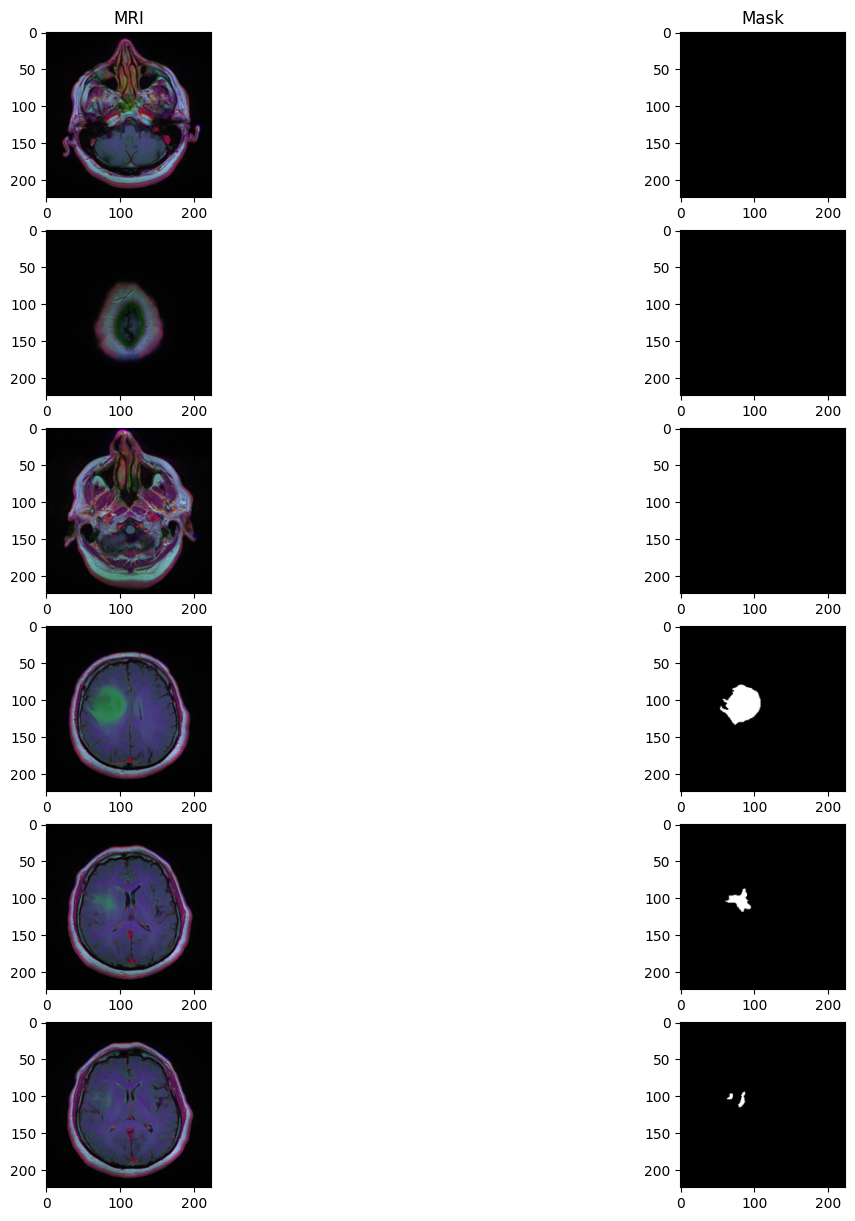

In [9]:
#display images of negative and positive samples - negative samples have an empty mask
fig, axs = plt.subplots(6,2, figsize=(15,15))
for ax, col in zip(axs[0], ['MRI', 'Mask']):
    ax.set_title(col)
    
display_imgs = empty_mask_samples+nonempty_mask_samples #concat lists for easy plotting
#print(display_imgs)
for i in range(len(display_imgs)):
    mask_path = display_imgs[i]
    img_path = mask_path[:mask_path.find('mask')-1]+'.tif'
    axs[i,0].imshow(np.array(cv2.imread(img_path)))
    axs[i,1].imshow(np.array(cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)))

In [10]:
## Data Augementation
train_transform = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

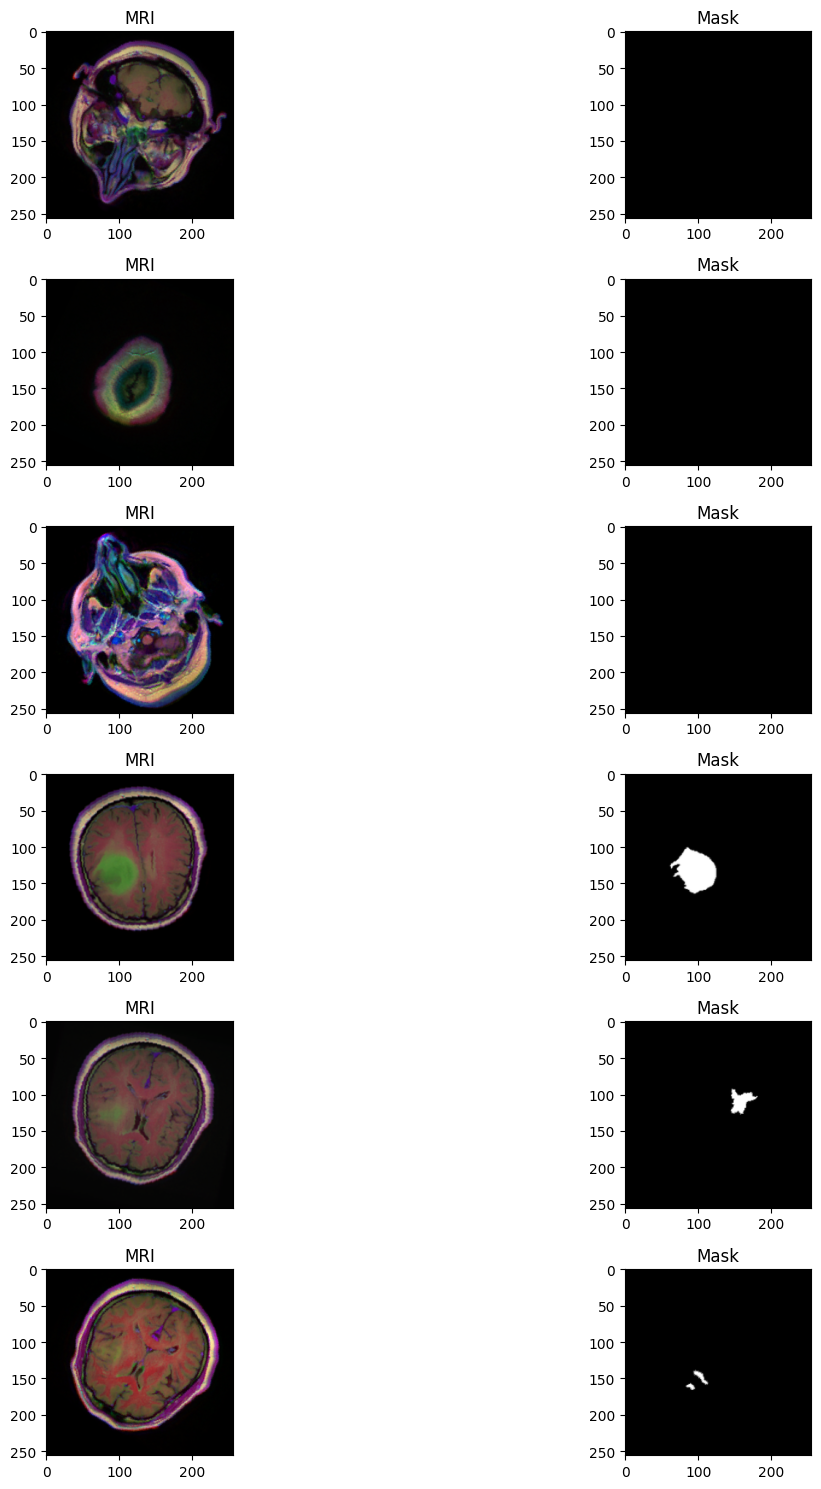

In [40]:
def preprocess_and_visualize(mask_samples):
    fig, axs = plt.subplots(len(mask_samples), 2, figsize=(15, 15))
    for i, mask_path in enumerate(mask_samples):
        img_path = mask_path[:mask_path.find('mask')-1] + '.tif'
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        img = train_transform(img)
        mask = train_transform(mask)
        
        img = img.permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
        mask = mask.squeeze().numpy()  # Remove channel dimension for mask
        
        axs[i, 0].imshow(img / 2 + 0.5)  # Unnormalize the image
        axs[i, 1].imshow(mask, cmap='gray')
        
        axs[i, 0].set_title("MRI")
        axs[i, 1].set_title("Mask")
    
    plt.tight_layout()
    plt.show()

# Concatenate empty and nonempty mask samples for visualization
display_imgs = empty_mask_samples + nonempty_mask_samples
preprocess_and_visualize(display_imgs)

### Creating Dataloaders

In [12]:
file_list = [] # List to store tuples of image path, mask path, and result

# Iterate over directories in the root directory
for directory in [os.path.join(root, x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        # Process only image files (not mask files)
        if 'mask' not in file:
            img_path = os.path.join(directory, file)
            mask_path = os.path.join(directory, file.replace('.tif', '_mask.tif'))
            # Check if the mask file exists and if it is non-empty
            result = 0
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                if mask is not None and np.max(mask) > 0:
                    result = 1
            # Append the (image_path, mask_path, pos_neg_result) tuple to the file_list
            file_list.append((img_path, mask_path, result))


In [13]:
class MRIDataset(Dataset):
    def __init__(self, inputs, transform=None,target_size=(224, 224)):
        self.inputs = inputs
        self.transform = transform
        self.target_size = target_size
        self.resize = transforms.Resize(self.target_size)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        img_path, mask_path, label = self.inputs[index]
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        img = np.array(img)
        mask = np.array(mask)
        
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        img = np.transpose(img, (2, 0, 1)) # Transpose image to (C, H, W)
        mask = np.expand_dims(mask, axis=0) # Add channel dimension to mask

        img = torch.from_numpy(img)
        mask = torch.from_numpy(mask)

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
            

        return img, mask


In [14]:
# Create the dataset
mri_dataset = MRIDataset([x for x in file_list if x[2] == 1])

# Split the dataset into training and validation sets
train_size = int(0.7 * len(mri_dataset))
val_size = len(mri_dataset) - train_size
train_set, val_set = random_split(mri_dataset, [train_size, val_size])

In [15]:
# Create DataLoaders
BATCH_SIZE = 8

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)

### Definig my model for U-Net

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # First convolution
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Second convolution
            nn.ReLU(inplace=True)  # ReLU activation
        )

    def forward(self, x):
        return self.conv_op(x)  # Forward pass through the double convolution


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)  # Double convolution block
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling

    def forward(self, x):
        down = self.conv(x)  # Apply double convolution
        p = self.pool(down)  # Apply max pooling
        return down, p  # Return both the convolution output and the pooled output


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)  # Transposed convolution
        self.conv = DoubleConv(in_channels, out_channels)  # Double convolution block

    def forward(self, x1, x2):
        x1 = self.up(x1)  # Upsample the input
        x = torch.cat([x1, x2], 1)  # Concatenate the upsampled input with the corresponding feature map from the encoder
        return self.conv(x)  # Apply double convolution


In [17]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Left side (contracting path / encoder)
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        # Bottom neck (bottleneck)
        self.bottle_neck = DoubleConv(512, 1024)

        # Right side (expanding path / decoder)
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # Down-sampling / encoder path
        down_1, p1 = self.down_convolution_1(x)  # First down-sampling
        down_2, p2 = self.down_convolution_2(p1)  # Second down-sampling
        down_3, p3 = self.down_convolution_3(p2)  # Third down-sampling
        down_4, p4 = self.down_convolution_4(p3)  # Fourth down-sampling

        # Bottleneck
        b = self.bottle_neck(p4)  # Bottleneck layer

        # Up-sampling / decoder path
        up_1 = self.up_convolution_1(b, down_4)  # First up-sampling
        up_2 = self.up_convolution_2(up_1, down_3)  # Second up-sampling
        up_3 = self.up_convolution_3(up_2, down_2)  # Third up-sampling
        up_4 = self.up_convolution_4(up_3, down_1)  # Fourth up-sampling

        # Output layer
        out = self.out(up_4)  # Output convolution to get the final prediction
        return out


### Defining a fine tuning transformer model (TransUnet)

In [ ]:
# utilised GPT 4.o here also
# Define the TransUNet model
class TransUNet(nn.Module):
    def __init__(self, num_classes):
        super(TransUNet, self).__init__()
        #Loads the ViT model with pre-trained weights, set to output only the feature maps.
        self.encoder = timm.create_model('vit_base_patch16_224', pretrained=True, features_only=True)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        features = self.encoder(x)
        x = features[-1]  # Use the last feature map from the encoder
        x = self.decoder(x)
        return x

### Creating Visualization 

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
def visualize_segmentation(model, data_loader, num_samples=5, device='cuda', model_result = 'results'):
    model.to(device)
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, 10))
    col_titles = ['MRI', 'Ground Truth', 'Predicted Mask']

    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)
    
    index = 0
    with torch.no_grad():
        for img, msk in data_loader:
            img, msk = img.to(device), msk.to(device)
            output = model(img)

            for j in range(img.size(0)):  # Iterate over batch size
                img_np = np.transpose(img[j].cpu().numpy(), (1, 2, 0))
                
                # Normalize the image if needed
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min()) * 255
                img_np = img_np.astype(np.uint8)
                
                axs[index, 0].imshow(img_np, cmap='gray', vmin=0, vmax=255)
                axs[index, 1].imshow(img_np, cmap='gray', vmin=0, vmax=255)
                axs[index, 1].imshow(msk[j].cpu().squeeze().numpy(), cmap='Blues', alpha=0.5)
                axs[index, 2].imshow(img_np, cmap='gray', vmin=0, vmax=255)
                axs[index, 2].imshow(output[j].cpu().squeeze().numpy(), cmap='Greens', alpha=0.5)
                index += 1
                if index >= num_samples:
                    break
            if index >= num_samples:
                break

    plt.tight_layout()
    plt.savefig(model_result)
    plt.show()


### Definig matrices to check the performance 

In [21]:
# Define the dice_coefficient function
def dice_coefficient(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    SMOOTH = 1e-6
    outputs = (outputs > threshold).float()
    labels = labels.float()
    intersection = (outputs * labels).sum((1, 2))
    dice = (2. * intersection + SMOOTH) / (outputs.sum((1, 2)) + labels.sum((1, 2)) + SMOOTH)
    return dice.mean()

# Define the iou_pytorch function
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    SMOOTH = 1e-6
    outputs = (outputs > threshold).int()
    labels = labels.int()
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    return iou.mean()

In [22]:
# Define the precision, recall, and f1_score functions
def precision_recall_f1(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    SMOOTH = 1e-6
    outputs = (outputs > threshold).float()
    labels = labels.float()
    
    true_positives = (outputs * labels).sum((1, 2))
    predicted_positives = outputs.sum((1, 2))
    actual_positives = labels.sum((1, 2))
    
    precision = (true_positives + SMOOTH) / (predicted_positives + SMOOTH)
    recall = (true_positives + SMOOTH) / (actual_positives + SMOOTH)
    f1 = 2 * (precision * recall) / (precision + recall + SMOOTH)
    
    return precision.mean(), recall.mean(), f1.mean()

### Representing the models and creating parameters for training

In [23]:
# Instantiate the models
model1 = TransUNet(num_classes=1).to(device)
model2 = UNet(in_channels=3, num_classes=1).to(device)

# Define separate optimizers for each model
optimizer1 = optim.AdamW(model1.parameters(), lr=5e-5)
optimizer2 = optim.AdamW(model2.parameters(), lr=3e-4)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Training parameters
EPOCHS = 40


In [24]:
#Utilised GPT 4.o to generate and modify this code 
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, epochs, device):
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for img, mask in tqdm(train_loader):
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, mask)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(device), mask.to(device)
                outputs = model(img)
                loss = criterion(outputs, mask)
                val_loss += loss.item()
                val_iou += iou_pytorch(outputs, mask).item()
                val_dice += dice_coefficient(outputs, mask).item()
                precision, recall, f1 = precision_recall_f1(outputs, mask)
                val_precision += precision.item()
                val_recall += recall.item()
                val_f1 += f1.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)

        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        val_dices.append(avg_val_dice)
        val_precisions.append(avg_val_precision)
        val_recalls.append(avg_val_recall)
        val_f1s.append(avg_val_f1)

        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val Dice: {avg_val_dice:.4f}, "
              f"Val Precision: {avg_val_precision:.4f}, Val Recall: {avg_val_recall:.4f}, Val F1: {avg_val_f1:.4f}")

    return train_losses, val_losses, val_ious, val_dices, val_precisions, val_recalls, val_f1s

In [25]:
# Train and evaluate UNet
print("Training UNet...")
unet_train_losses, unet_val_losses, unet_val_ious, unet_val_dices, unet_val_precisions, unet_val_recalls, unet_val_f1s = train_and_evaluate(model2, optimizer2, train_loader, val_loader, criterion, EPOCHS, device)

# Train and evaluate TransUNet
print("Training TransUNet...")
transunet_train_losses, transunet_val_losses, transunet_val_ious, transunet_val_dices, transunet_val_precisions, transunet_val_recalls, transunet_val_f1s = train_and_evaluate(model1, optimizer1, train_loader, val_loader, criterion, EPOCHS, device)


Training UNet...


100%|██████████| 121/121 [00:19<00:00,  6.06it/s]


Epoch 1/40, Train Loss: 0.1908
Epoch 1/40, Val Loss: 0.0720, Val IoU: 0.8263, Val Dice: 0.7998, Val Precision: 1.0000, Val Recall: 0.7998, Val F1: 0.7998


100%|██████████| 121/121 [00:08<00:00, 15.05it/s]


Epoch 2/40, Train Loss: 0.0682
Epoch 2/40, Val Loss: 0.0663, Val IoU: 0.8260, Val Dice: 0.7995, Val Precision: 1.0000, Val Recall: 0.7995, Val F1: 0.7995


100%|██████████| 121/121 [00:07<00:00, 16.27it/s]


Epoch 3/40, Train Loss: 0.0660
Epoch 3/40, Val Loss: 0.0584, Val IoU: 0.8652, Val Dice: 0.8563, Val Precision: 0.9702, Val Recall: 0.8696, Val F1: 0.8563


100%|██████████| 121/121 [00:08<00:00, 15.00it/s]


Epoch 4/40, Train Loss: 0.0605
Epoch 4/40, Val Loss: 0.0550, Val IoU: 0.8662, Val Dice: 0.8559, Val Precision: 0.9751, Val Recall: 0.8654, Val F1: 0.8559


100%|██████████| 121/121 [00:07<00:00, 15.82it/s]


Epoch 5/40, Train Loss: 0.0605
Epoch 5/40, Val Loss: 0.0546, Val IoU: 0.8679, Val Dice: 0.8549, Val Precision: 0.9841, Val Recall: 0.8571, Val F1: 0.8549


100%|██████████| 121/121 [00:07<00:00, 16.47it/s]


Epoch 6/40, Train Loss: 0.0596
Epoch 6/40, Val Loss: 0.0589, Val IoU: 0.8585, Val Dice: 0.8403, Val Precision: 0.9929, Val Recall: 0.8377, Val F1: 0.8403


100%|██████████| 121/121 [00:07<00:00, 15.81it/s]


Epoch 7/40, Train Loss: 0.0576
Epoch 7/40, Val Loss: 0.0537, Val IoU: 0.8701, Val Dice: 0.8575, Val Precision: 0.9854, Val Recall: 0.8583, Val F1: 0.8575


100%|██████████| 121/121 [00:07<00:00, 16.40it/s]


Epoch 8/40, Train Loss: 0.0557
Epoch 8/40, Val Loss: 0.0520, Val IoU: 0.8741, Val Dice: 0.8676, Val Precision: 0.9739, Val Recall: 0.8771, Val F1: 0.8676


100%|██████████| 121/121 [00:07<00:00, 15.67it/s]


Epoch 9/40, Train Loss: 0.0530
Epoch 9/40, Val Loss: 0.0496, Val IoU: 0.8686, Val Dice: 0.8552, Val Precision: 0.9906, Val Recall: 0.8527, Val F1: 0.8552


100%|██████████| 121/121 [00:07<00:00, 15.44it/s]


Epoch 10/40, Train Loss: 0.0488
Epoch 10/40, Val Loss: 0.0457, Val IoU: 0.8792, Val Dice: 0.8776, Val Precision: 0.9698, Val Recall: 0.8908, Val F1: 0.8776


100%|██████████| 121/121 [00:07<00:00, 15.98it/s]


Epoch 11/40, Train Loss: 0.0431
Epoch 11/40, Val Loss: 0.0395, Val IoU: 0.8872, Val Dice: 0.8909, Val Precision: 0.9651, Val Recall: 0.9062, Val F1: 0.8909


100%|██████████| 121/121 [00:07<00:00, 15.80it/s]


Epoch 12/40, Train Loss: 0.0382
Epoch 12/40, Val Loss: 0.0352, Val IoU: 0.8913, Val Dice: 0.8907, Val Precision: 0.9741, Val Recall: 0.8978, Val F1: 0.8907


100%|██████████| 121/121 [00:07<00:00, 15.76it/s]


Epoch 13/40, Train Loss: 0.0356
Epoch 13/40, Val Loss: 0.0378, Val IoU: 0.8874, Val Dice: 0.8871, Val Precision: 0.9683, Val Recall: 0.9004, Val F1: 0.8871


100%|██████████| 121/121 [00:07<00:00, 15.80it/s]


Epoch 14/40, Train Loss: 0.0327
Epoch 14/40, Val Loss: 0.0342, Val IoU: 0.8899, Val Dice: 0.8837, Val Precision: 0.9813, Val Recall: 0.8851, Val F1: 0.8837


100%|██████████| 121/121 [00:07<00:00, 15.84it/s]


Epoch 15/40, Train Loss: 0.0294
Epoch 15/40, Val Loss: 0.0296, Val IoU: 0.8959, Val Dice: 0.8888, Val Precision: 0.9875, Val Recall: 0.8858, Val F1: 0.8888


100%|██████████| 121/121 [00:07<00:00, 16.30it/s]


Epoch 16/40, Train Loss: 0.0272
Epoch 16/40, Val Loss: 0.0267, Val IoU: 0.9030, Val Dice: 0.9029, Val Precision: 0.9800, Val Recall: 0.9053, Val F1: 0.9029


100%|██████████| 121/121 [00:07<00:00, 15.36it/s]


Epoch 17/40, Train Loss: 0.0266
Epoch 17/40, Val Loss: 0.0278, Val IoU: 0.9011, Val Dice: 0.9050, Val Precision: 0.9682, Val Recall: 0.9170, Val F1: 0.9050


100%|██████████| 121/121 [00:07<00:00, 15.70it/s]


Epoch 18/40, Train Loss: 0.0227
Epoch 18/40, Val Loss: 0.0225, Val IoU: 0.9146, Val Dice: 0.9155, Val Precision: 0.9792, Val Recall: 0.9180, Val F1: 0.9155


100%|██████████| 121/121 [00:07<00:00, 15.77it/s]


Epoch 19/40, Train Loss: 0.0221
Epoch 19/40, Val Loss: 0.0228, Val IoU: 0.9141, Val Dice: 0.9191, Val Precision: 0.9738, Val Recall: 0.9259, Val F1: 0.9191


100%|██████████| 121/121 [00:07<00:00, 16.31it/s]


Epoch 20/40, Train Loss: 0.0212
Epoch 20/40, Val Loss: 0.0221, Val IoU: 0.9094, Val Dice: 0.9127, Val Precision: 0.9754, Val Recall: 0.9189, Val F1: 0.9127


100%|██████████| 121/121 [00:07<00:00, 15.30it/s]


Epoch 21/40, Train Loss: 0.0194
Epoch 21/40, Val Loss: 0.0237, Val IoU: 0.9125, Val Dice: 0.9115, Val Precision: 0.9835, Val Recall: 0.9105, Val F1: 0.9115


100%|██████████| 121/121 [00:07<00:00, 16.44it/s]


Epoch 22/40, Train Loss: 0.0190
Epoch 22/40, Val Loss: 0.0207, Val IoU: 0.9148, Val Dice: 0.9160, Val Precision: 0.9815, Val Recall: 0.9157, Val F1: 0.9160


100%|██████████| 121/121 [00:07<00:00, 16.42it/s]


Epoch 23/40, Train Loss: 0.0185
Epoch 23/40, Val Loss: 0.0200, Val IoU: 0.9187, Val Dice: 0.9243, Val Precision: 0.9765, Val Recall: 0.9290, Val F1: 0.9243


100%|██████████| 121/121 [00:07<00:00, 15.73it/s]


Epoch 24/40, Train Loss: 0.0176
Epoch 24/40, Val Loss: 0.0226, Val IoU: 0.9110, Val Dice: 0.9074, Val Precision: 0.9886, Val Recall: 0.9011, Val F1: 0.9074


100%|██████████| 121/121 [00:07<00:00, 15.68it/s]


Epoch 25/40, Train Loss: 0.0184
Epoch 25/40, Val Loss: 0.0253, Val IoU: 0.9026, Val Dice: 0.8954, Val Precision: 0.9866, Val Recall: 0.8911, Val F1: 0.8954


100%|██████████| 121/121 [00:07<00:00, 16.31it/s]


Epoch 26/40, Train Loss: 0.0180
Epoch 26/40, Val Loss: 0.0203, Val IoU: 0.9193, Val Dice: 0.9224, Val Precision: 0.9779, Val Recall: 0.9259, Val F1: 0.9224


100%|██████████| 121/121 [00:07<00:00, 15.30it/s]


Epoch 27/40, Train Loss: 0.0171
Epoch 27/40, Val Loss: 0.0208, Val IoU: 0.9194, Val Dice: 0.9192, Val Precision: 0.9825, Val Recall: 0.9187, Val F1: 0.9192


100%|██████████| 121/121 [00:07<00:00, 16.35it/s]


Epoch 28/40, Train Loss: 0.0172
Epoch 28/40, Val Loss: 0.0186, Val IoU: 0.9181, Val Dice: 0.9275, Val Precision: 0.9713, Val Recall: 0.9364, Val F1: 0.9275


100%|██████████| 121/121 [00:07<00:00, 15.64it/s]


Epoch 29/40, Train Loss: 0.0169
Epoch 29/40, Val Loss: 0.0209, Val IoU: 0.9168, Val Dice: 0.9160, Val Precision: 0.9853, Val Recall: 0.9132, Val F1: 0.9160


100%|██████████| 121/121 [00:07<00:00, 16.40it/s]


Epoch 30/40, Train Loss: 0.0159
Epoch 30/40, Val Loss: 0.0183, Val IoU: 0.9230, Val Dice: 0.9267, Val Precision: 0.9809, Val Recall: 0.9274, Val F1: 0.9267


100%|██████████| 121/121 [00:07<00:00, 16.43it/s]


Epoch 31/40, Train Loss: 0.0168
Epoch 31/40, Val Loss: 0.0209, Val IoU: 0.9161, Val Dice: 0.9211, Val Precision: 0.9731, Val Recall: 0.9280, Val F1: 0.9211


100%|██████████| 121/121 [00:07<00:00, 16.36it/s]


Epoch 32/40, Train Loss: 0.0181
Epoch 32/40, Val Loss: 0.0201, Val IoU: 0.9205, Val Dice: 0.9232, Val Precision: 0.9813, Val Recall: 0.9234, Val F1: 0.9232


100%|██████████| 121/121 [00:07<00:00, 15.80it/s]


Epoch 33/40, Train Loss: 0.0152
Epoch 33/40, Val Loss: 0.0188, Val IoU: 0.9189, Val Dice: 0.9289, Val Precision: 0.9691, Val Recall: 0.9401, Val F1: 0.9289


100%|██████████| 121/121 [00:07<00:00, 15.74it/s]


Epoch 34/40, Train Loss: 0.0138
Epoch 34/40, Val Loss: 0.0183, Val IoU: 0.9195, Val Dice: 0.9324, Val Precision: 0.9683, Val Recall: 0.9438, Val F1: 0.9324


100%|██████████| 121/121 [00:07<00:00, 15.82it/s]


Epoch 35/40, Train Loss: 0.0132
Epoch 35/40, Val Loss: 0.0189, Val IoU: 0.9228, Val Dice: 0.9269, Val Precision: 0.9815, Val Recall: 0.9272, Val F1: 0.9269


100%|██████████| 121/121 [00:07<00:00, 16.44it/s]


Epoch 36/40, Train Loss: 0.0129
Epoch 36/40, Val Loss: 0.0180, Val IoU: 0.9195, Val Dice: 0.9308, Val Precision: 0.9695, Val Recall: 0.9410, Val F1: 0.9308


100%|██████████| 121/121 [00:07<00:00, 16.54it/s]


Epoch 37/40, Train Loss: 0.0128
Epoch 37/40, Val Loss: 0.0184, Val IoU: 0.9200, Val Dice: 0.9325, Val Precision: 0.9700, Val Recall: 0.9425, Val F1: 0.9325


100%|██████████| 121/121 [00:07<00:00, 16.48it/s]


Epoch 38/40, Train Loss: 0.0129
Epoch 38/40, Val Loss: 0.0186, Val IoU: 0.9224, Val Dice: 0.9258, Val Precision: 0.9816, Val Recall: 0.9255, Val F1: 0.9258


100%|██████████| 121/121 [00:07<00:00, 16.33it/s]


Epoch 39/40, Train Loss: 0.0153
Epoch 39/40, Val Loss: 0.0209, Val IoU: 0.9165, Val Dice: 0.9186, Val Precision: 0.9770, Val Recall: 0.9215, Val F1: 0.9186


100%|██████████| 121/121 [00:07<00:00, 16.39it/s]


Epoch 40/40, Train Loss: 0.0140
Epoch 40/40, Val Loss: 0.0192, Val IoU: 0.9237, Val Dice: 0.9244, Val Precision: 0.9852, Val Recall: 0.9215, Val F1: 0.9244
Training TransUNet...


100%|██████████| 121/121 [00:17<00:00,  6.80it/s]


Epoch 1/40, Train Loss: 0.1047
Epoch 1/40, Val Loss: 0.0418, Val IoU: 0.8258, Val Dice: 0.7992, Val Precision: 1.0000, Val Recall: 0.7992, Val F1: 0.7992


100%|██████████| 121/121 [00:14<00:00,  8.27it/s]


Epoch 2/40, Train Loss: 0.0411
Epoch 2/40, Val Loss: 0.0385, Val IoU: 0.8253, Val Dice: 0.7987, Val Precision: 1.0000, Val Recall: 0.7987, Val F1: 0.7987


100%|██████████| 121/121 [00:14<00:00,  8.23it/s]


Epoch 3/40, Train Loss: 0.0376
Epoch 3/40, Val Loss: 0.0374, Val IoU: 0.8256, Val Dice: 0.7991, Val Precision: 1.0000, Val Recall: 0.7991, Val F1: 0.7991


100%|██████████| 121/121 [00:14<00:00,  8.30it/s]


Epoch 4/40, Train Loss: 0.0361
Epoch 4/40, Val Loss: 0.0374, Val IoU: 0.8257, Val Dice: 0.7992, Val Precision: 1.0000, Val Recall: 0.7992, Val F1: 0.7992


100%|██████████| 121/121 [00:14<00:00,  8.29it/s]


Epoch 5/40, Train Loss: 0.0306
Epoch 5/40, Val Loss: 0.0292, Val IoU: 0.8925, Val Dice: 0.8919, Val Precision: 0.9729, Val Recall: 0.8931, Val F1: 0.8919


100%|██████████| 121/121 [00:14<00:00,  8.34it/s]


Epoch 6/40, Train Loss: 0.0258
Epoch 6/40, Val Loss: 0.0261, Val IoU: 0.8982, Val Dice: 0.9016, Val Precision: 0.9683, Val Recall: 0.9067, Val F1: 0.9016


100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


Epoch 7/40, Train Loss: 0.0204
Epoch 7/40, Val Loss: 0.0202, Val IoU: 0.9176, Val Dice: 0.9192, Val Precision: 0.9740, Val Recall: 0.9201, Val F1: 0.9192


100%|██████████| 121/121 [00:14<00:00,  8.35it/s]


Epoch 8/40, Train Loss: 0.0158
Epoch 8/40, Val Loss: 0.0208, Val IoU: 0.9114, Val Dice: 0.9228, Val Precision: 0.9588, Val Recall: 0.9376, Val F1: 0.9228


100%|██████████| 121/121 [00:14<00:00,  8.26it/s]


Epoch 9/40, Train Loss: 0.0149
Epoch 9/40, Val Loss: 0.0196, Val IoU: 0.9185, Val Dice: 0.9244, Val Precision: 0.9711, Val Recall: 0.9281, Val F1: 0.9244


100%|██████████| 121/121 [00:15<00:00,  7.98it/s]


Epoch 10/40, Train Loss: 0.0130
Epoch 10/40, Val Loss: 0.0201, Val IoU: 0.9188, Val Dice: 0.9240, Val Precision: 0.9708, Val Recall: 0.9275, Val F1: 0.9240


100%|██████████| 121/121 [00:14<00:00,  8.28it/s]


Epoch 11/40, Train Loss: 0.0119
Epoch 11/40, Val Loss: 0.0195, Val IoU: 0.9185, Val Dice: 0.9253, Val Precision: 0.9703, Val Recall: 0.9299, Val F1: 0.9253


100%|██████████| 121/121 [00:14<00:00,  8.28it/s]


Epoch 12/40, Train Loss: 0.0114
Epoch 12/40, Val Loss: 0.0206, Val IoU: 0.9191, Val Dice: 0.9212, Val Precision: 0.9758, Val Recall: 0.9212, Val F1: 0.9212


100%|██████████| 121/121 [00:14<00:00,  8.29it/s]


Epoch 13/40, Train Loss: 0.0116
Epoch 13/40, Val Loss: 0.0194, Val IoU: 0.9163, Val Dice: 0.9286, Val Precision: 0.9640, Val Recall: 0.9375, Val F1: 0.9286


100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


Epoch 14/40, Train Loss: 0.0107
Epoch 14/40, Val Loss: 0.0199, Val IoU: 0.9207, Val Dice: 0.9241, Val Precision: 0.9739, Val Recall: 0.9263, Val F1: 0.9241


100%|██████████| 121/121 [00:14<00:00,  8.35it/s]


Epoch 15/40, Train Loss: 0.0102
Epoch 15/40, Val Loss: 0.0213, Val IoU: 0.9204, Val Dice: 0.9217, Val Precision: 0.9781, Val Recall: 0.9201, Val F1: 0.9217


100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


Epoch 16/40, Train Loss: 0.0097
Epoch 16/40, Val Loss: 0.0200, Val IoU: 0.9203, Val Dice: 0.9260, Val Precision: 0.9736, Val Recall: 0.9282, Val F1: 0.9260


100%|██████████| 121/121 [00:14<00:00,  8.24it/s]


Epoch 17/40, Train Loss: 0.0094
Epoch 17/40, Val Loss: 0.0209, Val IoU: 0.9187, Val Dice: 0.9255, Val Precision: 0.9702, Val Recall: 0.9298, Val F1: 0.9255


100%|██████████| 121/121 [00:14<00:00,  8.35it/s]


Epoch 18/40, Train Loss: 0.0091
Epoch 18/40, Val Loss: 0.0203, Val IoU: 0.9154, Val Dice: 0.9299, Val Precision: 0.9607, Val Recall: 0.9431, Val F1: 0.9299


100%|██████████| 121/121 [00:14<00:00,  8.35it/s]


Epoch 19/40, Train Loss: 0.0090
Epoch 19/40, Val Loss: 0.0203, Val IoU: 0.9183, Val Dice: 0.9294, Val Precision: 0.9662, Val Recall: 0.9378, Val F1: 0.9294


100%|██████████| 121/121 [00:14<00:00,  8.44it/s]


Epoch 20/40, Train Loss: 0.0086
Epoch 20/40, Val Loss: 0.0209, Val IoU: 0.9181, Val Dice: 0.9272, Val Precision: 0.9675, Val Recall: 0.9338, Val F1: 0.9272


100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


Epoch 21/40, Train Loss: 0.0082
Epoch 21/40, Val Loss: 0.0209, Val IoU: 0.9193, Val Dice: 0.9274, Val Precision: 0.9695, Val Recall: 0.9328, Val F1: 0.9274


100%|██████████| 121/121 [00:14<00:00,  8.34it/s]


Epoch 22/40, Train Loss: 0.0079
Epoch 22/40, Val Loss: 0.0214, Val IoU: 0.9185, Val Dice: 0.9283, Val Precision: 0.9684, Val Recall: 0.9348, Val F1: 0.9283


100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


Epoch 23/40, Train Loss: 0.0080
Epoch 23/40, Val Loss: 0.0221, Val IoU: 0.9211, Val Dice: 0.9250, Val Precision: 0.9752, Val Recall: 0.9258, Val F1: 0.9250


100%|██████████| 121/121 [00:14<00:00,  8.32it/s]


Epoch 24/40, Train Loss: 0.0080
Epoch 24/40, Val Loss: 0.0214, Val IoU: 0.9175, Val Dice: 0.9279, Val Precision: 0.9668, Val Recall: 0.9351, Val F1: 0.9279


100%|██████████| 121/121 [00:15<00:00,  7.99it/s]


Epoch 25/40, Train Loss: 0.0078
Epoch 25/40, Val Loss: 0.0217, Val IoU: 0.9183, Val Dice: 0.9297, Val Precision: 0.9658, Val Recall: 0.9383, Val F1: 0.9297


100%|██████████| 121/121 [00:15<00:00,  8.05it/s]


Epoch 26/40, Train Loss: 0.0078
Epoch 26/40, Val Loss: 0.0223, Val IoU: 0.9190, Val Dice: 0.9259, Val Precision: 0.9705, Val Recall: 0.9312, Val F1: 0.9259


100%|██████████| 121/121 [00:14<00:00,  8.26it/s]


Epoch 27/40, Train Loss: 0.0077
Epoch 27/40, Val Loss: 0.0221, Val IoU: 0.9189, Val Dice: 0.9276, Val Precision: 0.9698, Val Recall: 0.9330, Val F1: 0.9276


100%|██████████| 121/121 [00:14<00:00,  8.30it/s]


Epoch 28/40, Train Loss: 0.0074
Epoch 28/40, Val Loss: 0.0229, Val IoU: 0.9193, Val Dice: 0.9270, Val Precision: 0.9715, Val Recall: 0.9308, Val F1: 0.9270


100%|██████████| 121/121 [00:14<00:00,  8.33it/s]


Epoch 29/40, Train Loss: 0.0073
Epoch 29/40, Val Loss: 0.0230, Val IoU: 0.9203, Val Dice: 0.9269, Val Precision: 0.9716, Val Recall: 0.9309, Val F1: 0.9269


100%|██████████| 121/121 [00:14<00:00,  8.18it/s]


Epoch 30/40, Train Loss: 0.0082
Epoch 30/40, Val Loss: 0.0222, Val IoU: 0.9215, Val Dice: 0.9283, Val Precision: 0.9728, Val Recall: 0.9312, Val F1: 0.9283


100%|██████████| 121/121 [00:14<00:00,  8.47it/s]


Epoch 31/40, Train Loss: 0.0078
Epoch 31/40, Val Loss: 0.0214, Val IoU: 0.9190, Val Dice: 0.9300, Val Precision: 0.9679, Val Recall: 0.9372, Val F1: 0.9300


100%|██████████| 121/121 [00:14<00:00,  8.28it/s]


Epoch 32/40, Train Loss: 0.0073
Epoch 32/40, Val Loss: 0.0223, Val IoU: 0.9201, Val Dice: 0.9289, Val Precision: 0.9700, Val Recall: 0.9344, Val F1: 0.9289


100%|██████████| 121/121 [00:14<00:00,  8.32it/s]


Epoch 33/40, Train Loss: 0.0070
Epoch 33/40, Val Loss: 0.0228, Val IoU: 0.9188, Val Dice: 0.9307, Val Precision: 0.9669, Val Recall: 0.9393, Val F1: 0.9307


100%|██████████| 121/121 [00:14<00:00,  8.29it/s]


Epoch 34/40, Train Loss: 0.0068
Epoch 34/40, Val Loss: 0.0224, Val IoU: 0.9199, Val Dice: 0.9299, Val Precision: 0.9696, Val Recall: 0.9358, Val F1: 0.9299


100%|██████████| 121/121 [00:14<00:00,  8.37it/s]


Epoch 35/40, Train Loss: 0.0068
Epoch 35/40, Val Loss: 0.0236, Val IoU: 0.9198, Val Dice: 0.9278, Val Precision: 0.9702, Val Recall: 0.9325, Val F1: 0.9278


100%|██████████| 121/121 [00:14<00:00,  8.25it/s]


Epoch 36/40, Train Loss: 0.0068
Epoch 36/40, Val Loss: 0.0225, Val IoU: 0.9191, Val Dice: 0.9301, Val Precision: 0.9677, Val Recall: 0.9377, Val F1: 0.9301


100%|██████████| 121/121 [00:14<00:00,  8.29it/s]


Epoch 37/40, Train Loss: 0.0066
Epoch 37/40, Val Loss: 0.0224, Val IoU: 0.9184, Val Dice: 0.9305, Val Precision: 0.9670, Val Recall: 0.9388, Val F1: 0.9305


100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


Epoch 38/40, Train Loss: 0.0064
Epoch 38/40, Val Loss: 0.0221, Val IoU: 0.9190, Val Dice: 0.9301, Val Precision: 0.9684, Val Recall: 0.9366, Val F1: 0.9301


100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


Epoch 39/40, Train Loss: 0.0064
Epoch 39/40, Val Loss: 0.0224, Val IoU: 0.9194, Val Dice: 0.9291, Val Precision: 0.9685, Val Recall: 0.9359, Val F1: 0.9291


100%|██████████| 121/121 [00:14<00:00,  8.30it/s]


Epoch 40/40, Train Loss: 0.0064
Epoch 40/40, Val Loss: 0.0234, Val IoU: 0.9193, Val Dice: 0.9299, Val Precision: 0.9689, Val Recall: 0.9363, Val F1: 0.9299


### Visualizing the predictions

#### 1 TransUnet Predictions

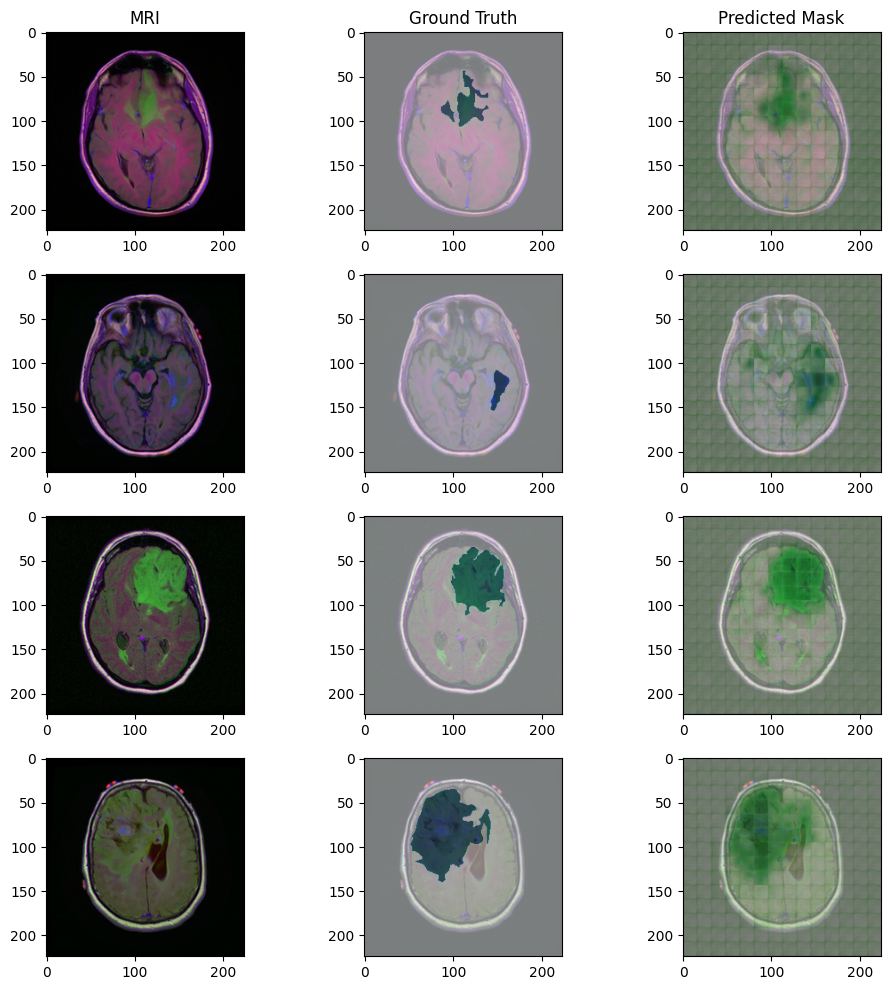

In [46]:
visualize_segmentation(model1, val_loader, num_samples=4, device='cuda',model_result='TransUnet')


#### 2 U-Net predictions

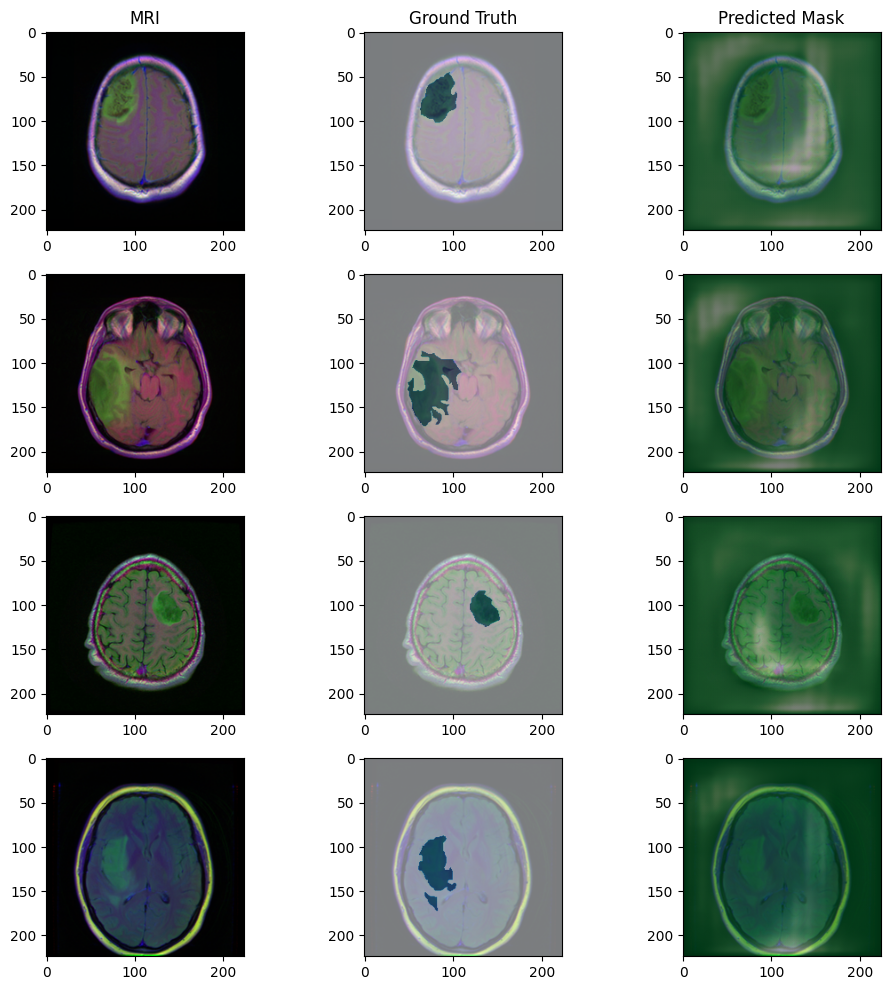

In [47]:
visualize_segmentation(model2, val_loader, num_samples=4, device='cuda', model_result ='Unet')


<Figure size 640x480 with 0 Axes>

### Comparing the performance 

In [28]:
# Compare performance
print(f"UNet - Validation IoU: {unet_val_ious[-1]:.4f}, Validation Dice: {unet_val_dices[-1]:.4f}, "
      f"Validation Precision: {unet_val_precisions[-1]:.4f}, Validation Recall: {unet_val_recalls[-1]:.4f}, Validation F1: {unet_val_f1s[-1]:.4f}")
print(f"TransUNet - Validation IoU: {transunet_val_ious[-1]:.4f}, Validation Dice: {transunet_val_dices[-1]:.4f}, "
      f"Validation Precision: {transunet_val_precisions[-1]:.4f}, Validation Recall: {transunet_val_recalls[-1]:.4f}, Validation F1: {transunet_val_f1s[-1]:.4f}")

if unet_val_ious[-1] > transunet_val_ious[-1]:
    print("UNet performs better based on IoU.")
else:
    print("TransUNet performs better based on IoU.")

if unet_val_precisions[-1] > transunet_val_precisions[-1]:
    print("UNet performs better based on Precision.")
else:
    print("TransUNet performs better based on Precision.")

if unet_val_recalls[-1] > transunet_val_recalls[-1]:
    print("UNet performs better based on Recall.")
else:
    print("TransUNet performs better based on Recall.")


UNet - Validation IoU: 0.9237, Validation Dice: 0.9244, Validation Precision: 0.9852, Validation Recall: 0.9215, Validation F1: 0.9244
TransUNet - Validation IoU: 0.9193, Validation Dice: 0.9299, Validation Precision: 0.9689, Validation Recall: 0.9363, Validation F1: 0.9299
UNet performs better based on IoU.
UNet performs better based on Precision.
TransUNet performs better based on Recall.


### Plotting my results

##### Since the main component we need is train loss and validation loss and also some other matrics calculation plotting

In [49]:
# Plotting function
def plot_metrics(unet_metrics, transunet_metrics, metric_name, ylabel, graph_result ='result'):
    plt.figure(figsize=(8, 5))
    epochs = range(1, EPOCHS + 1)
    plt.plot(epochs, unet_metrics, label='UNet')
    plt.plot(epochs, transunet_metrics, label='TransUNet')
    plt.title(f'{metric_name} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.savefig(graph_result)
    plt.legend()
    plt.show()

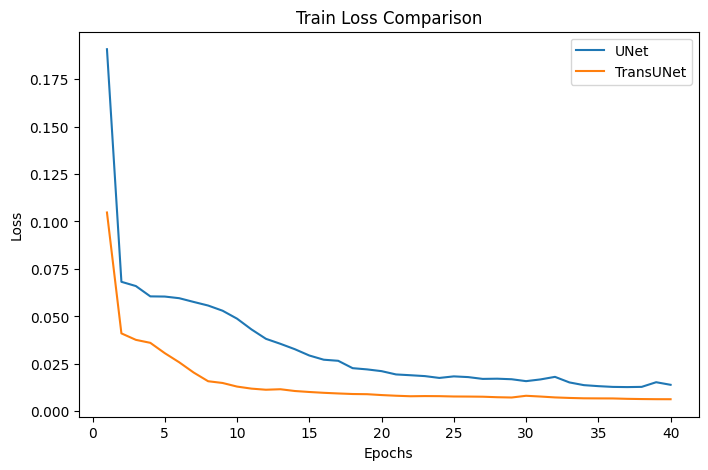

In [50]:
# Plot Train Loss
plot_metrics(unet_train_losses, transunet_train_losses, 'Train Loss', 'Loss',graph_result='train_loss')

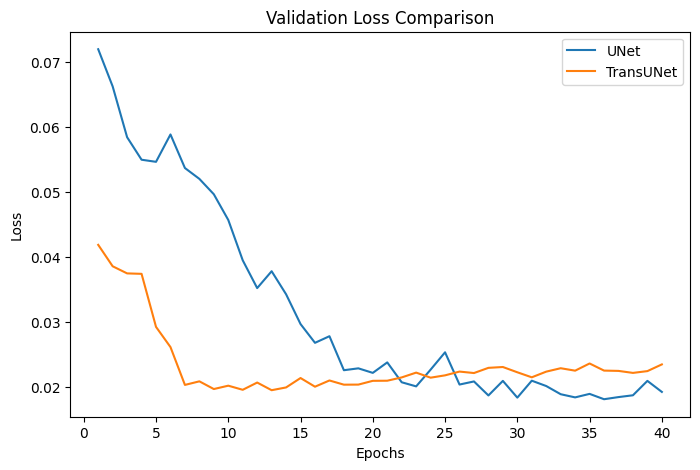

In [51]:
# Plot Validation Loss
plot_metrics(unet_val_losses, transunet_val_losses, 'Validation Loss', 'Loss',graph_result='val_loss')

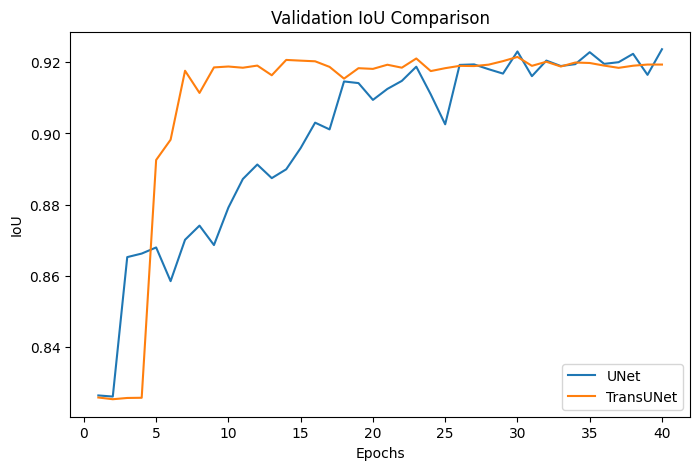

In [52]:
# Plot Validation IoU
plot_metrics(unet_val_ious, transunet_val_ious, 'Validation IoU', 'IoU',graph_result='IOU')

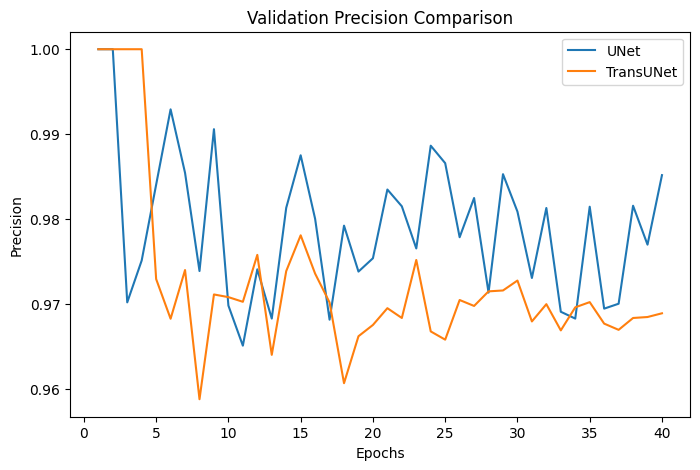

In [53]:
# Plot Validation Precision
plot_metrics(unet_val_precisions, transunet_val_precisions, 'Validation Precision', 'Precision',graph_result='Precision')

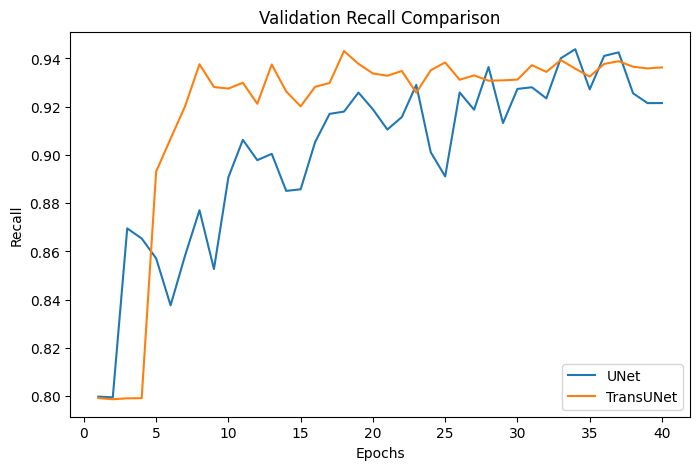

In [54]:
# Plot Validation Recall
plot_metrics(unet_val_recalls, transunet_val_recalls, 'Validation Recall', 'Recall',graph_result='recall')

[References]

1 - https://github.com/uygarkurt/UNet-PyTorch/blob/main/main.py (And for defining the structure for Unet I have utilised this github repo)

2- https://github.com/zackdilan/Semantic-Segmentation-with-Unet/blob/master/Unet%20Evaluation.ipynb (for performing EDA I hvae utilised this kaggle code)

3- https://www.kaggle.com/code/abhitpandey007/liver-seg-transunet

4- For some of the task like fine tuning of TransUnet, I hvae seeked helped form ChatGPT and also I have used ChatGPT for some modificiations in my code (like defining a whole "train_and_evaulate" function)